In [139]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Activation, Conv2D, AveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Recall, Precision, TruePositives, TrueNegatives, FalseNegatives, FalsePositives, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB7

In [104]:
data_path = "/content/3_Colored_Brain_Tumor_Dataset.npz"
grayscale_data_path = "/content/Brain_Tumor_Dataset.npz"

In [130]:
#   Grayscale data
g_data = np.load(grayscale_data_path)
g_X = g_data['X']
g_y = g_data['y']
g_X_train, g_X_test, g_y_train, g_y_test = train_test_split(g_X, g_y, test_size=0.2, random_state=42, shuffle=True)

In [106]:
#   Colored data
c_data = np.load(data_path)
c_X = c_data['X']
c_y = c_data['y']
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, c_y, test_size=0.2, random_state=42, shuffle=True)

In [107]:
c_X.shape

(253, 224, 224, 3)

### Transfert Learning:
#### 1- ResNet50

In [108]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
base_model.trainable = False

In [109]:
input = Input(shape=input_shape)
b_model = base_model(input, training=False)
gap = GlobalAveragePooling2D()(b_model)
dense1 = Dense(128, activation="relu", name="FC-1")(gap)
dropout = Dropout(0.2)(dense1)
dense2 = Dense(64, activation="relu", name="FC-2")(dropout)
prediction = Dense(1, activation="sigmoid", name="Prediction_Layer")(dense2)

model = Model(input, prediction)
model.summary()

Model: "functional_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC-1 (Dense)                    │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC-2 (Dense)                    │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Prediction_Layer (Dense)        │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 270,593 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [110]:
#   Compilation et entrainement du modéle
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(threshold=0.5, name="accuracy"), Recall(), Precision(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])
fit_history = model.fit(c_X_train, c_y_train, epochs=25)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 682ms/step - accuracy: 0.5853 - false_negatives_20: 10.0000 - false_positives_20: 43.8750 - loss: 0.6896 - precision_20: 0.6271 - recall_20: 0.8536 - true_negatives_20: 4.6250 - true_positives_20: 76.0000
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5483 - false_negatives_20: 24.2500 - false_positives_20: 31.6250 - loss: 0.6654 - precision_20: 0.6043 - recall_20: 0.6470 - true_negatives_20: 21.1250 - true_positives_20: 57.5000
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6545 - false_negatives_20: 0.3750 - false_positives_20: 47.3750 - loss: 0.6412 - precision_20: 0.6553 - recall_20: 0.9970 - true_negatives_20: 0.2500 - true_positives_20: 86.5000    
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7015 - false_negatives_20: 25.7500 - false_positives_20: 16.7500 - loss: 0.6042 - precision_20: 0.8047 - recall_20: 0.7132 - true_negatives_20: 31.2500 - true_positives_20: 60.7500
Epoch 5/25
7/7 ━━━━━━

In [111]:
def model_evaluation(metrics):
  print("Loss: ", np.round(metrics[0], 2))
  print("Accuracy: ", np.round(metrics[1], 2))
  print("Recall: ", np.round(metrics[2], 2))
  print("Precision: ", np.round(metrics[3], 2))
  print("True Positives: ", int(metrics[4]))
  print("True Negatives: ", int(metrics[5]))
  print("False Positives: ", int(metrics[6]))
  print("False Negatives: ", int(metrics[7]))


In [112]:
resnet_model_metrics = model.evaluate(c_X_test, c_y_test)
model_evaluation(resnet_model_metrics)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7206 - false_negatives_20: 7.6667 - false_positives_20: 5.0000 - loss: 0.5624 - precision_20: 0.7667 - recall_20: 0.6797 - true_negatives_20: 16.0000 - true_positives_20: 16.0000
Loss:  0.57
Accuracy:  0.71
Recall:  0.67
Precision:  0.75
True Positives:  18
True Negatives:  18
False Positives:  6
False Negatives:  9


#### 2.a- VGG

In [113]:
vgg_model = tf.keras.applications.VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
vgg_model.trainable = False
v_model = Sequential(name="VGG16")
v_model.add(vgg_model)
v_model.add(GlobalAveragePooling2D())
v_model.add(Dense(128, activation="relu"))
v_model.add(Dropout(0.2))
v_model.add(Dense(64, activation="relu"))
v_model.add(Dense(1, activation="sigmoid"))
v_model.summary()

Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,788,673 (56.41 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [114]:
v_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(threshold=0.5, name="accuracy"), Recall(), Precision(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])
vgg_fit_history = v_model.fit(c_X_train, c_y_train, epochs=25)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.6031 - false_negatives_21: 5.7500 - false_positives_21: 46.7500 - loss: 0.6614 - precision_21: 0.6310 - recall_21: 0.9106 - true_negatives_21: 2.0000 - true_positives_21: 80.0000
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.6492 - false_negatives_21: 1.8750 - false_positives_21: 46.2500 - loss: 0.6282 - precision_21: 0.6522 - recall_21: 0.9830 - true_negatives_21: 1.6250 - true_positives_21: 84.7500
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.6861 - false_negatives_21: 1.6250 - false_positives_21: 39.7500 - loss: 0.6078 - precision_21: 0.6712 - recall_21: 0.9813 - true_negatives_21: 10.0000 - true_positives_21: 83.1250
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6990 - false_negatives_21: 0.0000e+00 - false_positives_21: 42.3750 - loss: 0.5901 - precision_21: 0.6890 - recall_21: 1.0000 - true_negatives_21: 4.3750 - true_positives_21: 87.7500
Epoch 5/25
7/7 ━━━━━━━━

In [115]:
vgg_model_metrics = v_model.evaluate(c_X_test, c_y_test)
model_evaluation(vgg_model_metrics)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 588ms/step - accuracy: 0.7598 - false_negatives_21: 3.6667 - false_positives_21: 7.0000 - loss: 0.4461 - precision_21: 0.7402 - recall_21: 0.8424 - true_negatives_21: 14.0000 - true_positives_21: 20.0000
Loss:  0.43
Accuracy:  0.76
Recall:  0.85
Precision:  0.74
True Positives:  23
True Negatives:  16
False Positives:  8
False Negatives:  4


####  2.b- VGG19


In [116]:
from os import name
vgg_model_19 = tf.keras.applications.VGG19(input_shape=input_shape, weights='imagenet', include_top=False)
vgg_model_19.trainable = False
v_19_model = Sequential(name="VGG19_Model")
v_19_model.add(vgg_model)
v_19_model.add(GlobalAveragePooling2D(name="Flatten_layer"))
v_19_model.add(Dense(128, activation="relu", name="FC-1"))
v_19_model.add(Dropout(0.2, name="Dropout_layer"))
v_19_model.add(Dense(64, activation="relu", name="FC-2"))
v_19_model.add(Dense(1, activation="sigmoid", name="Output_Layer"))
v_19_model.summary()

Model: "VGG19_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_layer                   │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC-1 (Dense)                    │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC-2 (Dense)                    │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,788,673 (56.41 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [117]:
v_19_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(threshold=0.5, name="accuracy"), Recall(), Precision(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])
vgg_19_fit_history = v_19_model.fit(c_X_train, c_y_train, epochs=25)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - accuracy: 0.5449 - false_negatives_22: 21.5000 - false_positives_22: 35.1250 - loss: 0.6770 - precision_22: 0.5833 - recall_22: 0.6246 - true_negatives_22: 16.8750 - true_positives_22: 61.0000
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.5949 - false_negatives_22: 0.0000e+00 - false_positives_22: 50.8750 - loss: 0.6943 - precision_22: 0.5922 - recall_22: 1.0000 - true_negatives_22: 1.3750 - true_positives_22: 82.2500
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.6485 - false_negatives_22: 3.1250 - false_positives_22: 43.2500 - loss: 0.5995 - precision_22: 0.6476 - recall_22: 0.9551 - true_negatives_22: 7.2500 - true_positives_22: 80.8750
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.6693 - false_negatives_22: 0.0000e+00 - false_positives_22: 43.6250 - loss: 0.5536 - precision_22: 0.6510 - recall_22: 1.0000 - true_negatives_22: 7.0000 - true_positives_22: 83.8750
Epoch 5/25
7/7 ━━━

In [118]:
vgg_19_model_metrics = v_19_model.evaluate(c_X_test, c_y_test)
model_evaluation(vgg_19_model_metrics)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 722ms/step - accuracy: 0.7702 - false_negatives_22: 0.0000e+00 - false_positives_22: 10.3333 - loss: 0.5313 - precision_22: 0.6976 - recall_22: 1.0000 - true_negatives_22: 10.6667 - true_positives_22: 23.6667
Loss:  0.51
Accuracy:  0.76
Recall:  1.0
Precision:  0.69
True Positives:  27
True Negatives:  12
False Positives:  12
False Negatives:  0


##### 3- Inception

In [119]:
inception = tf.keras.applications.InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)
inception.trainable = False

In [120]:
inception_model = Sequential()
inception_model.add(inception)
inception_model.add(GlobalAveragePooling2D())
inception_model.add(Dense(128, activation="relu"))
inception_model.add(Dropout(0.2))
inception_model.add(Dense(64, activation="relu"))
inception_model.add(Dense(1, activation="sigmoid"))
inception_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,073,377 (84.20 MB)

 Trainable params: 270,593 (1.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [121]:
inception_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(threshold=0.5, name="accuracy"), Recall(), Precision(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])
inception_fit_history = inception_model.fit(c_X_train, c_y_train, epochs=25)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 782ms/step - accuracy: 0.6206 - false_negatives_23: 22.5000 - false_positives_23: 27.3750 - loss: 0.6831 - precision_23: 0.6977 - recall_23: 0.7273 - true_negatives_23: 20.8750 - true_positives_23: 63.7500
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7715 - false_negatives_23: 2.5000 - false_positives_23: 27.0000 - loss: 0.4444 - precision_23: 0.7448 - recall_23: 0.9664 - true_negatives_23: 21.8750 - true_positives_23: 83.1250
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8418 - false_negatives_23: 13.0000 - false_positives_23: 7.5000 - loss: 0.3412 - precision_23: 0.9054 - recall_23: 0.8233 - true_negatives_23: 43.2500 - true_positives_23: 70.7500
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8802 - false_negatives_23: 5.3750 - false_positives_23: 10.3750 - loss: 0.3082 - precision_23: 0.8845 - recall_23: 0.9477 - true_negatives_23: 35.1250 - true_positives_23: 83.6250
Epoch 5/25
7/7 ━━━━━━━━━━

In [122]:
inception_model_metrics = inception_model.evaluate(c_X_test, c_y_test)
model_evaluation(inception_model_metrics)


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9034 - false_negatives_23: 1.0000 - false_positives_23: 3.3333 - loss: 0.7539 - precision_23: 0.8741 - recall_23: 0.9557 - true_negatives_23: 17.6667 - true_positives_23: 22.6667
Loss:  0.77
Accuracy:  0.9
Recall:  0.96
Precision:  0.87
True Positives:  26
True Negatives:  20
False Positives:  4
False Negatives:  1


##### 4- Xception

In [123]:
xception = tf.keras.applications.Xception(input_shape=input_shape, weights='imagenet', include_top=False)
xception.trainable = False

In [124]:
xception_model = Sequential(name="xception_model")
xception_model.add(xception)
xception_model.add(Flatten())
xception_model.add(Dense(128, activation="relu"))
xception_model.add(Dropout(0.2))
xception_model.add(Dense(64, activation="relu"))
xception_model.add(Dense(1, activation="sigmoid"))
xception_model.summary()

Model: "xception_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,714,985 (128.61 MB)

 Trainable params: 12,853,505 (49.03 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [125]:
xception_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(threshold=0.5, name="accuracy"), Recall(), Precision(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])
xception_fit_history = xception_model.fit(c_X_train, c_y_train, epochs=25)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 642ms/step - accuracy: 0.6777 - false_negatives_24: 22.1250 - false_positives_24: 19.6250 - loss: 4.0510 - precision_24: 0.7600 - recall_24: 0.7088 - true_negatives_24: 30.8750 - true_positives_24: 61.8750
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.7817 - false_negatives_24: 17.0000 - false_positives_24: 11.7500 - loss: 1.7080 - precision_24: 0.8756 - recall_24: 0.7656 - true_negatives_24: 38.0000 - true_positives_24: 67.7500
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.8694 - false_negatives_24: 7.2500 - false_positives_24: 10.5000 - loss: 0.7383 - precision_24: 0.8765 - recall_24: 0.9210 - true_negatives_24: 39.6250 - true_positives_24: 77.1250
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9682 - false_negatives_24: 1.5000 - false_positives_24: 3.6250 - loss: 0.1554 - precision_24: 0.9678 - recall_24: 0.9838 - true_negatives_24: 44.3750 - true_positives_24: 85.0000
Epoch 5/25
7/7 ━━━━━━━

In [126]:
xception_model_metrics = xception_model.evaluate(c_X_test, c_y_test)
model_evaluation(xception_model_metrics)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8538 - false_negatives_24: 1.6667 - false_positives_24: 5.0000 - loss: 1.2063 - precision_24: 0.8183 - recall_24: 0.9310 - true_negatives_24: 16.0000 - true_positives_24: 22.0000
Loss:  1.08
Accuracy:  0.84
Recall:  0.93
Precision:  0.81
True Positives:  25
True Negatives:  18
False Positives:  6
False Negatives:  2


####  5- EfficientNet

In [127]:
efficientNet = EfficientNetB7(input_shape=input_shape, weights='imagenet', include_top=False)
efficientNet.trainable = False
efficientNet_model = Sequential(name="efficientNet_model")
efficientNet_model.add(efficientNet)
efficientNet_model.add(GlobalAveragePooling2D())
efficientNet_model.add(Dense(128, activation="relu"))
efficientNet_model.add(Dropout(0.2))
efficientNet_model.add(Dense(64, activation="relu"))
efficientNet_model.add(Dense(1, activation="sigmoid"))
efficientNet_model.summary()

Model: "efficientNet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,433,816 (245.80 MB)

 Trainable params: 336,129 (1.28 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [128]:
efficientNet_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(threshold=0.5, name="accuracy"), Recall(), Precision(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])
efficientNet_fit_history = efficientNet_model.fit(c_X_train, c_y_train, epochs=25)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.5145 - false_negatives_25: 27.2500 - false_positives_25: 36.8750 - loss: 0.7266 - precision_25: 0.6142 - recall_25: 0.6298 - true_negatives_25: 14.5000 - true_positives_25: 55.8750
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.6612 - false_negatives_25: 0.0000e+00 - false_positives_25: 47.1250 - loss: 0.6707 - precision_25: 0.6612 - recall_25: 1.0000 - true_negatives_25: 0.0000e+00 - true_positives_25: 87.3750
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.6164 - false_negatives_25: 12.1250 - false_positives_25: 42.5000 - loss: 0.6754 - precision_25: 0.6469 - recall_25: 0.8858 - true_negatives_25: 6.6250 - true_positives_25: 73.2500
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.6548 - false_negatives_25: 1.0000 - false_positives_25: 45.7500 - loss: 0.6525 - precision_25: 0.6520 - recall_25: 0.9831 - true_negatives_25: 3.2500 - true_positives_25: 84.5000
Epoch 5/25
7/7 ━━

In [129]:
efficientNet_model_metrics = efficientNet_model.evaluate(c_X_test, c_y_test)
model_evaluation(efficientNet_model_metrics)

2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.5535 - false_negatives_25: 0.0000e+00 - false_positives_25: 20.0000 - loss: 0.6918 - precision_25: 0.5428 - recall_25: 1.0000 - true_negatives_25: 1.0000 - true_positives_25: 23.6667
Loss:  0.69
Accuracy:  0.55
Recall:  1.0
Precision:  0.54
True Positives:  27
True Negatives:  1
False Positives:  23
False Negatives:  0


#### 6- LeNet

In [133]:
from re import L
input_shape = (224, 224, 1)
lenet = Sequential(name="LeNet")
lenet.add(Input(shape=input_shape))
lenet.add(Conv2D(filters=6, kernel_size=(5, 5), activation="tanh"))
lenet.add(AveragePooling2D(pool_size=(2, 2)))
lenet.add(Activation("sigmoid"))
lenet.add(Conv2D(filters=16, kernel_size=(5, 5), activation="tanh"))
lenet.add(AveragePooling2D(pool_size=(2, 2)))
lenet.add(Activation("sigmoid"))
lenet.add(Conv2D(filters=120, kernel_size=(5, 5), activation="tanh"))
lenet.add(Flatten())
lenet.add(Dense(120, activation="tanh"))
lenet.add(Dropout(0.2))
lenet.add(Dense(84, activation="tanh"))
lenet.add(Dense(1, activation="sigmoid"))
lenet.summary()

Model: "LeNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_391 (Conv2D)             │ (None, 220, 220, 6)    │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_38            │ (None, 110, 110, 6)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_378 (Activation)     │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_392 (Conv2D)             │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_39            │ (None, 53, 53, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_379 (Activation)     │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_393 (Conv2D)             │ (None, 49, 49, 120)    │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 288120)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 120)            │    34,574,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,635,461 (132.12 MB)

 Trainable params: 34,635,461 (132.12 MB)

 Non-trainable params: 0 (0.00 B)

In [135]:
lenet.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(threshold=0.5, name="accuracy"), Recall(), Precision(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])
lenet_fit_history = lenet.fit(g_X_train, g_y_train, epochs=25)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6135 - false_negatives_27: 10.0000 - false_positives_27: 41.6250 - loss: 1.5627 - precision_27: 0.6678 - recall_27: 0.8358 - true_negatives_27: 7.0000 - true_positives_27: 75.8750
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5933 - false_negatives_27: 13.7500 - false_positives_27: 43.8750 - loss: 0.8623 - precision_27: 0.6242 - recall_27: 0.8887 - true_negatives_27: 6.1250 - true_positives_27: 70.7500
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3616 - false_negatives_27: 80.3750 - false_positives_27: 3.0000 - loss: 0.8625 - precision_27: 0.5439 - recall_27: 0.0557 - true_negatives_27: 44.6250 - true_positives_27: 6.5000
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6432 - false_negatives_27: 4.8750 - false_positives_27: 43.2500 - loss: 0.6700 - precision_27: 0.6512 - recall_27: 0.9183 - true_negatives_27: 7.5000 - true_positives_27: 78.8750
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━

In [136]:
lenet_model_metrics = lenet.evaluate(g_X_test, g_y_test)
model_evaluation(lenet_model_metrics)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.5300 - false_negatives_27: 0.0000e+00 - false_positives_27: 21.0000 - loss: 0.6935 - precision_27: 0.5300 - recall_27: 1.0000 - true_negatives_27: 0.0000e+00 - true_positives_27: 23.6667
Loss:  0.69
Accuracy:  0.53
Recall:  1.0
Precision:  0.53
True Positives:  27
True Negatives:  0
False Positives:  24
False Negatives:  0


### Evaluation

In [145]:
for i in resnet_model_metrics:
  print(i)

0.56651371717453
0.7058823704719543
0.6666666865348816
0.75
18.0
18.0
6.0
9.0


#### 1- Loss

/tmp/ipython-input-158-1196418374.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(models))  # 10 couleurs max


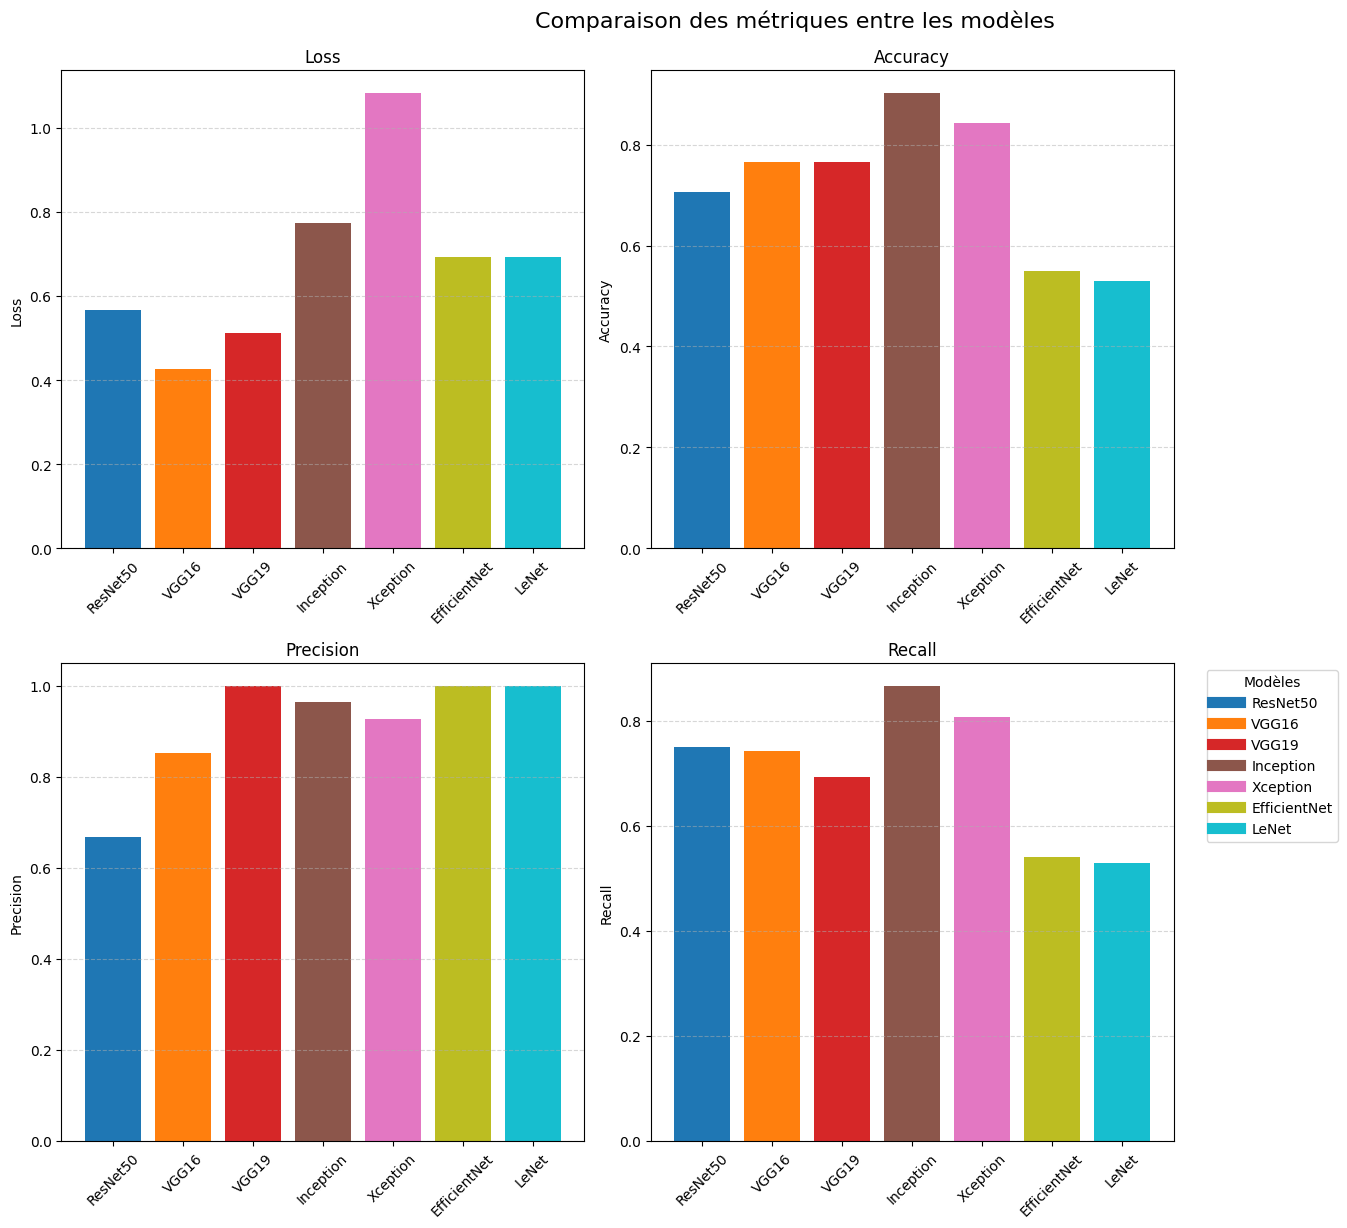

In [158]:
metric_names = ["Loss", "Accuracy", "Precision", "Recall"]

metrics_dict = {
    "ResNet50": resnet_model_metrics,
    "VGG16": vgg_model_metrics,
    "VGG19": vgg_19_model_metrics,
    "Inception": inception_model_metrics,
    "Xception": xception_model_metrics,
    "EfficientNet": efficientNet_model_metrics,
    "LeNet": lenet_model_metrics
}

models = list(metrics_dict.keys())
num_metrics = len(metric_names)

# Définir une couleur unique par modèle
colors = plt.cm.get_cmap('tab10', len(models))  # 10 couleurs max

plt.figure(figsize=(16, 12))

for i in range(num_metrics):
    plt.subplot(2, 2, i + 1)
    values = [metrics_dict[model][i] for model in models]

    # Affiche chaque barre modèle par modèle, avec sa couleur
    for j, (model, val) in enumerate(zip(models, values)):
        plt.bar(model, val, color=colors(j))

    plt.title(metric_names[i])
    plt.ylabel(metric_names[i])
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

# Créer une légende commune (hors des subplots)
handles = [plt.Line2D([0], [0], color=colors(i), lw=8) for i in range(len(models))]
plt.legend(handles, models, title="Modèles", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # laisser de la place à droite pour la légende
plt.suptitle("Comparaison des métriques entre les modèles", fontsize=16, y=1.02)
plt.show()